# GenCP demo

This notebook demonstrates how to generate synthetic GCP image chips from OSM raster maps.

A test set for the demonstration is available in the folder genCP_demo/data/dataset/test . It contains OSM raster maps over LaCrau site (MGRS tile 31TFJ).

GenCP HR model's weights can be downloaded **here (TODO add link to Zenodo)** and should be added in a "checkpoints" folder inside genCP_demo. This model has been trained on RGB images (S2 L2A TCI band).

Generated images are saved in the data/fake_images folder. The final GenCP database (geo-referenced synthetic images) is saved in the folder "GenCP_DB".

Note: Generated images are 8 bit images.


## Installation

In [ ]:
!pip install -r requirements_HR.txt

In [2]:
import os
import random
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt


## Visualize OSM raster example

Variable **dataroot** indicates path to input OSM rasters for visualization.

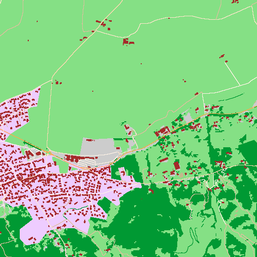

In [3]:
# path to test set
dataroot = "./data/dataset/test"

# show test data example
img_example = random.choice(os.listdir(dataroot))
img = Image.open(os.path.join(dataroot, img_example))
display(img)

## Generate images for all test samples

This section allows to generate synthetic images from OSM rasters provided as demonstration data. To generate images from your own OSM rasters, change the dataroot path. Please refer to the [data section](https://gitlab2.telespazio.fr/isl/tim/genCP/-/blob/genCP_deliv/README.md#data) to see guidelines on how to generate OSM rasters compatible with the model's weights provided.

Add option `--gpu_ids -1` to run on CPU if GPU is not available

* `--dataroot` indicates path to training dataset
* `--name` indicates the name the experiment/model (use "genCP_HR_B04_model" to test HR model trained on B04 band)
* `--checkpoints_dir` indicates the path to checkpoints folder where model's weights are saved
* `--results_dir` indicates the path to output folder for saving generated images
* `--model` is set to "test" to indicate testing mode
* `--dataset_mode` is set to "single" to indicate that only OSM rasters will be provided as inputs
* `--norm` is set to "batch" to indicate that batch normalization has been used during training
* `--netG` is set to "unet_256" to indicate that U-Net 256 was used as backbone for the generator during training

Note: HR model trained on band B04 will generate 3-channels images as band B04 as been stacked to create image pairs with OSM raster (3-channels) for training. Select only the first channel of the generated images if you need single band images.

In [4]:
!python ../test.py  --dataroot "./data/dataset" --name "genCP_HR_RGB_model" --model "test" --results_dir "./data/fake_images" --checkpoints_dir "./checkpoints" --dataset_mode "single" --norm "batch" --netG "unet_256"

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./data/dataset                	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

## Create GenCP database

Geo-reference generated images and save files in GenCP_DB folder.

* `-t` indicates path to generated images (not geo-referenced)
* `-i` indicates path to input test data (geo-refrenced OSM rasters)
* `-o` indicates path to output folder for geo-referenced generated images

In [ ]:
!python gencp_georeferencing.py -t "./data/fake_images/genCP_HR_RGB_model/test_latest/images" -i "./data/dataset/test" -o "./data/GenCP_DB"

## Visualize generated images

This section allows to visualize generated images and the corresponding OSM rasters. The image displayed is choosen randomly among all generated images.

Variable **generated_dataroot** indicates path to generated images (not geo-referenced) for visualization.

Text(0.5, 1.0, 'Generated Image')

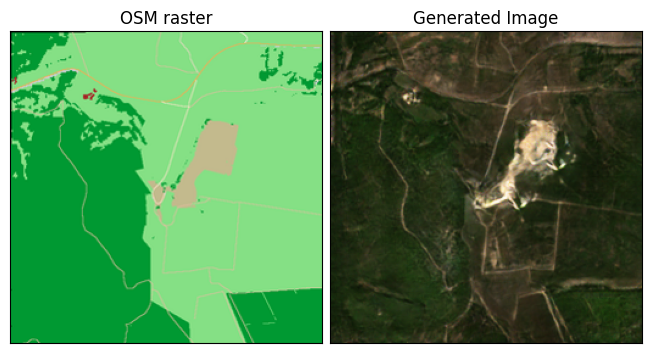

In [12]:
# path to test set
generated_dataroot = "./data/fake_images/genCP_HR_RGB_model/test_latest/images"

# select random generated image
img_example = random.choice(os.listdir(generated_dataroot))
img_basename = img_example[:-9]
osm_raster_path = os.path.join(generated_dataroot, img_basename + "_real.png")
gen_img_path = os.path.join(generated_dataroot, img_basename + "_fake.png")

osm_img = Image.open(osm_raster_path)
gen_img = Image.open(gen_img_path)


%matplotlib inline

# display images
fig, ax = plt.subplots(1,2, constrained_layout=True)
for i in range(2):
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[0].imshow(osm_img)
ax[0].set_title('OSM raster')
ax[1].imshow(gen_img)
ax[1].set_title('Generated Image')
